## Import Statements

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, precision_recall_curve, accuracy_score,
    average_precision_score, f1_score, confusion_matrix
)
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv("telesurgery_dataset_anamoly.csv")

print("Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

print("\nSummary Statistics:\n", df.describe())

Shape: (4000, 15)

Missing Values:
 Robot Gesture ID                 0
Gesture Type                     0
Gesture Coordinates (x, y, z)    0
Timestamp                        0
Gesture Duration (sec)           0
Message ID                       0
Sender                           0
Receiver                         0
Encryption Status                0
Network Latency (ms)             0
Data Transfer Rate (Mbps)        0
Response Time (sec)              0
Threat Detected                  0
synthesized                      0
t_offset                         0
dtype: int64

Duplicates: 0

Summary Statistics:
        Robot Gesture ID  Gesture Duration (sec)    Message ID  \
count       4000.000000             4000.000000   4000.000000   
mean           5.453000                3.750942  54765.611000   
std            2.886499                2.050856  25872.825939   
min            1.000000                0.500000  10047.000000   
25%            3.000000                2.134375  32551.000000   

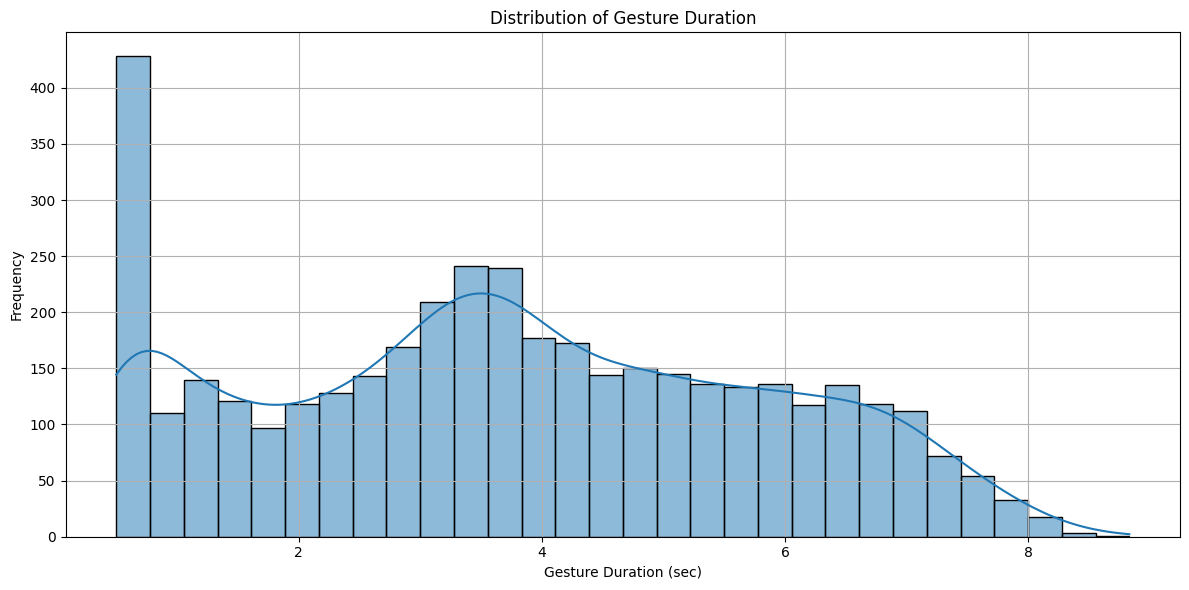

In [3]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Gesture Duration (sec)'], kde=True, bins=30)
plt.title("Distribution of Gesture Duration")
plt.xlabel("Gesture Duration (sec)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

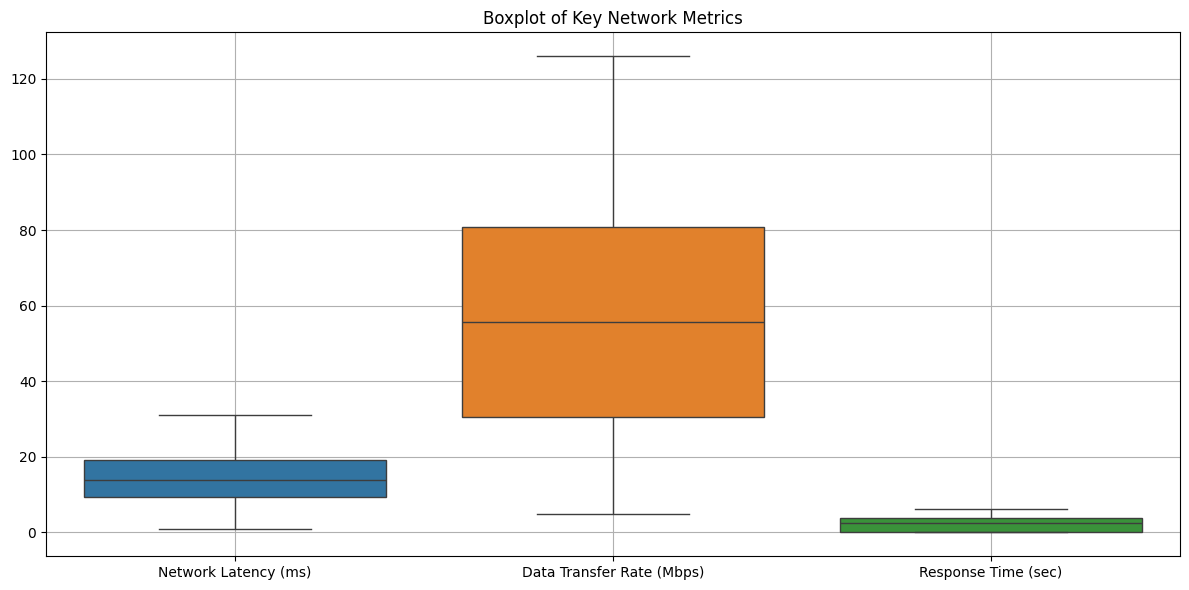

In [4]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Network Latency (ms)', 'Data Transfer Rate (Mbps)', 'Response Time (sec)']])
plt.title("Boxplot of Key Network Metrics")
plt.grid(True)
plt.tight_layout()
plt.show()

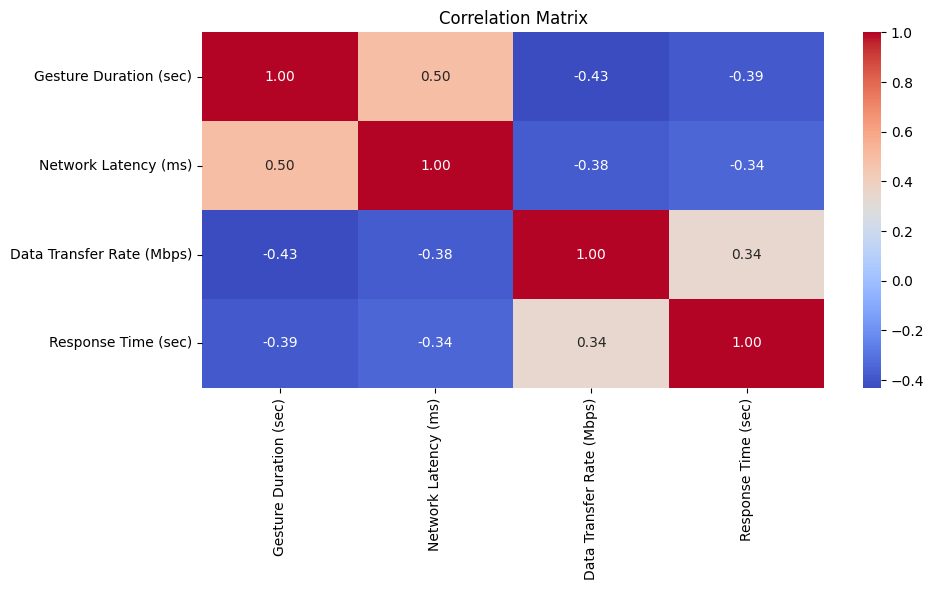

In [5]:
plt.figure(figsize=(10, 6))
correlation = df[['Gesture Duration (sec)', 'Network Latency (ms)', 'Data Transfer Rate (Mbps)', 'Response Time (sec)']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

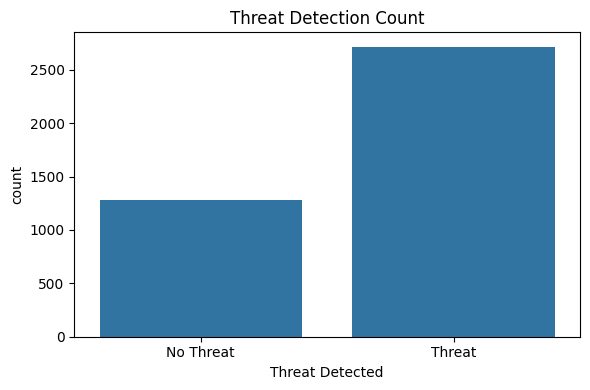

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Threat Detected', data=df)
plt.title("Threat Detection Count")
plt.xticks([0, 1], ['No Threat', 'Threat'])
plt.tight_layout()
plt.show()

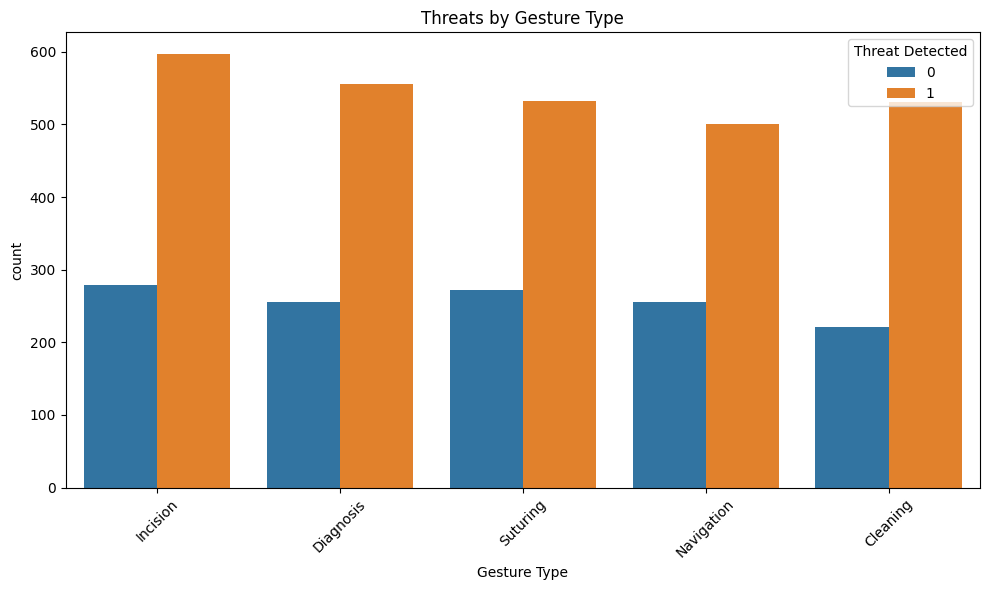

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Gesture Type', hue='Threat Detected', data=df)
plt.title("Threats by Gesture Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
df_model = df.copy()

df_model.drop(columns=['Sender','Receiver','Message ID', 'Encryption Status', 't_offset'], errors='ignore', inplace=True)

categorical_cols = df_model.select_dtypes(include='object').columns
label_encoders = {}



for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    
sequence_data = []
sequence_labels = []

for i in range(len(df_model) - 3):
    rows = df_model.iloc[i:i+4]
    if list(rows['synthesized']) == [label_encoders['synthesized'].transform(['yes'])[0]] * 3 + [label_encoders['synthesized'].transform(['no'])[0]]:
        context_rows = rows.iloc[:3].drop(columns=['Timestamp', 'Threat Detected', 'synthesized'])
        label = rows.iloc[3]['Threat Detected']
        flattened = context_rows.values.flatten()
        sequence_data.append(flattened)
        sequence_labels.append(label)

X = np.array(sequence_data)
y = np.array(sequence_labels)

X = SimpleImputer(strategy='mean').fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


 Model: Decision Tree
 Accuracy: 0.7333
 Weighted F1-score: 0.7372
 Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.71      0.66       107
         1.0       0.82      0.75      0.78       193

    accuracy                           0.73       300
   macro avg       0.72      0.73      0.72       300
weighted avg       0.75      0.73      0.74       300



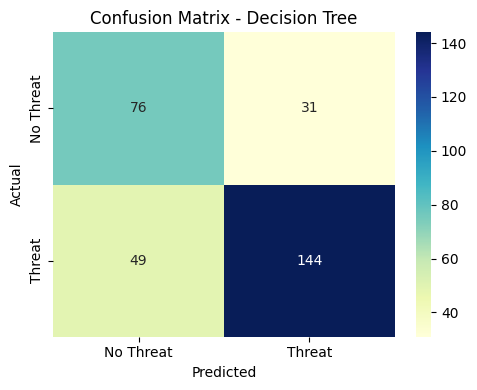


 Model: Random Forest
 Accuracy: 0.8467
 Weighted F1-score: 0.8430
 Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.70      0.77       107
         1.0       0.85      0.93      0.89       193

    accuracy                           0.85       300
   macro avg       0.85      0.81      0.83       300
weighted avg       0.85      0.85      0.84       300



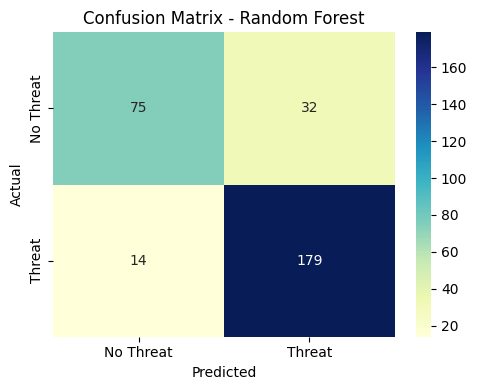


 Model: AdaBoost
 Accuracy: 0.8500
 Weighted F1-score: 0.8467
 Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.71      0.77       107
         1.0       0.85      0.93      0.89       193

    accuracy                           0.85       300
   macro avg       0.85      0.82      0.83       300
weighted avg       0.85      0.85      0.85       300



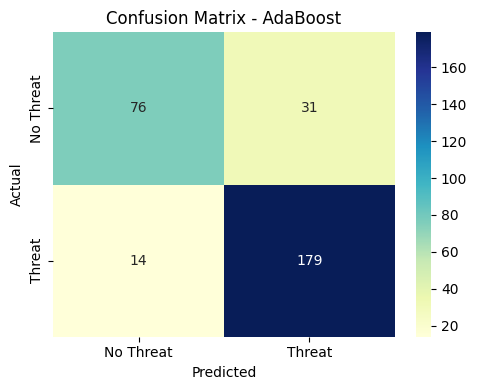


 Model: Gradient Boosting
 Accuracy: 0.8333
 Weighted F1-score: 0.8314
 Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.72      0.75       107
         1.0       0.85      0.90      0.87       193

    accuracy                           0.83       300
   macro avg       0.82      0.81      0.81       300
weighted avg       0.83      0.83      0.83       300



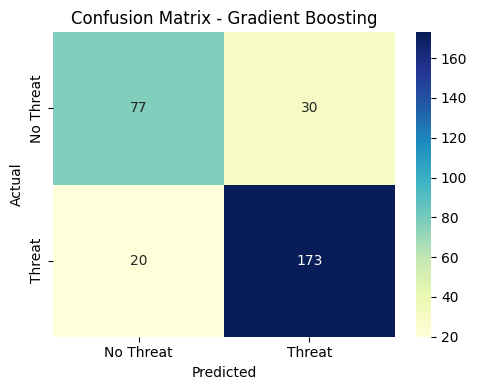


 Model: XGBoost
 Accuracy: 0.8100
 Weighted F1-score: 0.8052
 Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.64      0.71       107
         1.0       0.82      0.90      0.86       193

    accuracy                           0.81       300
   macro avg       0.80      0.77      0.78       300
weighted avg       0.81      0.81      0.81       300



C:\Users\rohan\anaconda3\envs\sml-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:25:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


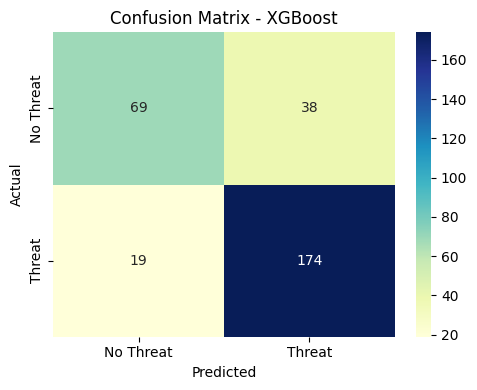

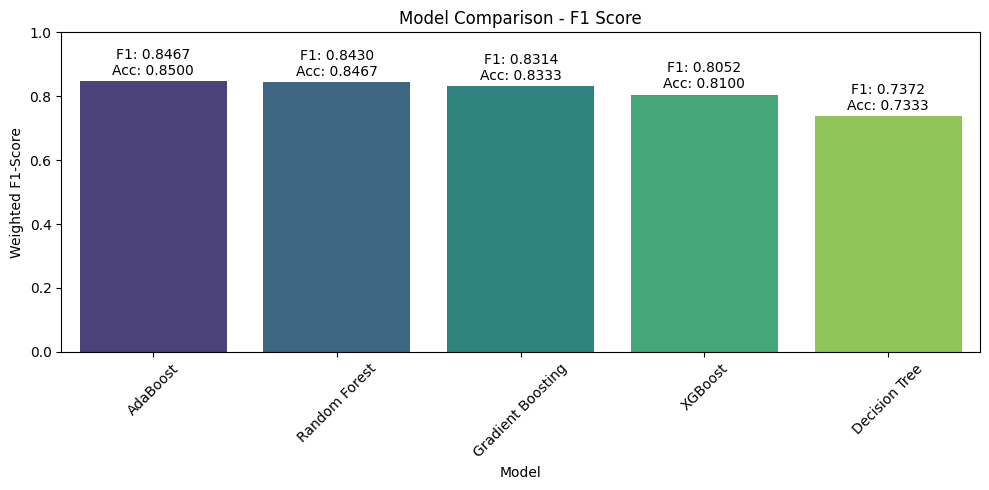

In [9]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(max_depth= 10, min_samples_split= 5, n_estimators=200, random_state=42),
    'AdaBoost': AdaBoostClassifier(learning_rate=1, n_estimators=500, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['weighted avg']['f1-score']
    
    results.append((name, acc, f1))

    print(f"\n Model: {name}")
    print(f" Accuracy: {acc:.4f}")
    print(f" Weighted F1-score: {f1:.4f}")
    print(" Classification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['No Threat', 'Threat'], yticklabels=['No Threat', 'Threat'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()

summary_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1-Score'])
summary_df = summary_df.sort_values(by='F1-Score', ascending=False)

plt.figure(figsize=(10, 5))
ax  = sns.barplot(x='Model', y='F1-Score', hue='Model', data=summary_df, palette='viridis', legend=False)


for bar, (_, row) in zip(ax.patches, summary_df.iterrows()):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    f1 = row['F1-Score']
    acc = row['Accuracy']
    ax.text(
        x, y + 0.01,
        f"F1: {f1:.4f}\nAcc: {acc:.4f}",
        ha='center', va='bottom',
        fontsize=10
    )

plt.title('Model Comparison - F1 Score')
plt.ylabel('Weighted F1-Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Hyper-parameter Tuning

In [10]:
param_grids = {
    'Random Forest': {
        'n_estimators': [200, 500],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'AdaBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.5, 1.0, 1.5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

base_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


Running GridSearchCV for Random Forest:


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500}
Accuracy: 0.8500, Weighted F1-score: 0.8467

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.71      0.77       107
         1.0       0.85      0.93      0.89       193

    accuracy                           0.85       300
   macro avg       0.85      0.82      0.83       300
weighted avg       0.85      0.85      0.85       300



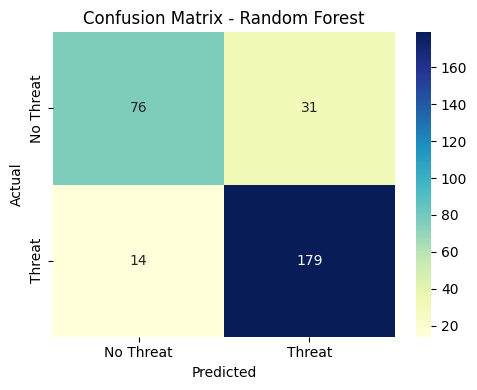


 All Configurations Tried for Random Forest:


,params,mean_test_score,std_test_score,rank_test_score
3,"{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500}",0.832189,0.020650,1
11,"{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 500}",0.832189,0.020650,1
1,"{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}",0.830750,0.020181,3
9,"{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}",0.830750,0.020181,3
4,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}",0.830740,0.018108,5
5,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500}",0.830740,0.015693,5
7,"{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500}",0.830740,0.018141,5
0,"{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}",0.829311,0.017940,8
8,"{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}",0.829311,0.017940,8
6,"{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}",0.829301,0.015609,10



Running GridSearchCV for AdaBoost:


Best Parameters for AdaBoost: {'learning_rate': 0.5, 'n_estimators': 300}
Accuracy: 0.8633, Weighted F1-score: 0.8594

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.71      0.79       107
         1.0       0.86      0.95      0.90       193

    accuracy                           0.86       300
   macro avg       0.87      0.83      0.84       300
weighted avg       0.87      0.86      0.86       300



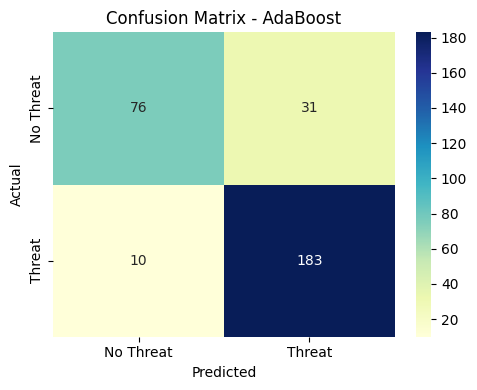


 All Configurations Tried for AdaBoost:


,params,mean_test_score,std_test_score,rank_test_score
2,"{'learning_rate': 0.5, 'n_estimators': 300}",0.842210,0.018440,1
3,"{'learning_rate': 1.0, 'n_estimators': 100}",0.840781,0.016270,2
1,"{'learning_rate': 0.5, 'n_estimators': 200}",0.839342,0.017032,3
0,"{'learning_rate': 0.5, 'n_estimators': 100}",0.837903,0.018246,4
4,"{'learning_rate': 1.0, 'n_estimators': 200}",0.832199,0.020064,5
5,"{'learning_rate': 1.0, 'n_estimators': 300}",0.830761,0.020597,6
7,"{'learning_rate': 1.5, 'n_estimators': 200}",0.814974,0.028790,7
6,"{'learning_rate': 1.5, 'n_estimators': 100}",0.809219,0.018629,8
8,"{'learning_rate': 1.5, 'n_estimators': 300}",0.809219,0.025643,8



Running GridSearchCV for Gradient Boosting:


Best Parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.8533, Weighted F1-score: 0.8503

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.72      0.78       107
         1.0       0.86      0.93      0.89       193

    accuracy                           0.85       300
   macro avg       0.85      0.82      0.83       300
weighted avg       0.85      0.85      0.85       300



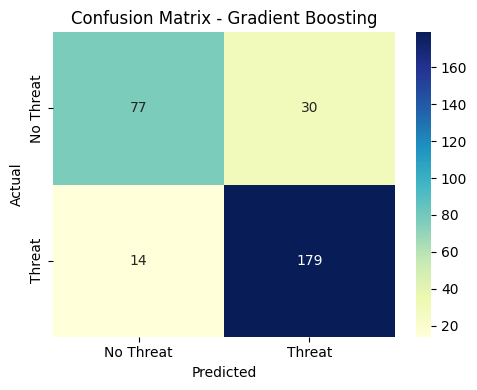


 All Configurations Tried for Gradient Boosting:


,params,mean_test_score,std_test_score,rank_test_score
0,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}",0.830740,0.016979,1
4,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",0.826413,0.006624,2
1,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}",0.824974,0.005393,3
2,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}",0.822107,0.015849,4
3,"{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}",0.817790,0.013306,5
5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}",0.814954,0.017476,6
6,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}",0.813525,0.015871,7
7,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}",0.809219,0.017533,8



Running GridSearchCV for XGBoost:


Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 0.8533, Weighted F1-score: 0.8494

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77       107
         1.0       0.85      0.94      0.89       193

    accuracy                           0.85       300
   macro avg       0.86      0.82      0.83       300
weighted avg       0.85      0.85      0.85       300



C:\Users\rohan\anaconda3\envs\sml-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:25:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


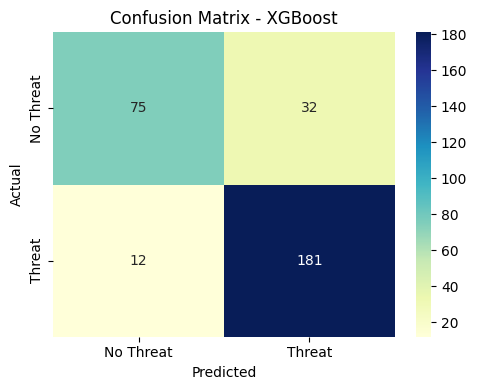


 All Configurations Tried for XGBoost:


,params,mean_test_score,std_test_score,rank_test_score
37,"{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}",0.839322,0.016632,1
1,"{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}",0.837893,0.020463,2
4,"{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}",0.837893,0.018838,2
6,"{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}",0.836444,0.017202,4
36,"{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}",0.835036,0.019520,5
...,...,...,...,...
67,"{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}",0.806321,0.015626,68
27,"{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}",0.804861,0.020099,69
26,"{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}",0.803422,0.026054,70
30,"{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}",0.799126,0.015884,71


In [11]:
results = []

for name in base_models:
    print(f"\nRunning GridSearchCV for {name}:\n")
    
    grid = GridSearchCV(base_models[name], param_grids[name], cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['weighted avg']['f1-score']
    results.append((name, acc, f1))
    
    print(f"\nBest Parameters for {name}: {grid.best_params_}")
    print(f"Accuracy: {acc:.4f}, Weighted F1-score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['No Threat', 'Threat'], yticklabels=['No Threat', 'Threat'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    pd.set_option('display.max_colwidth', None)

    print(f"\n All Configurations Tried for {name}:")
    cv_results = pd.DataFrame(grid.cv_results_)
    score_cols = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    display(cv_results[score_cols].sort_values(by='rank_test_score'))

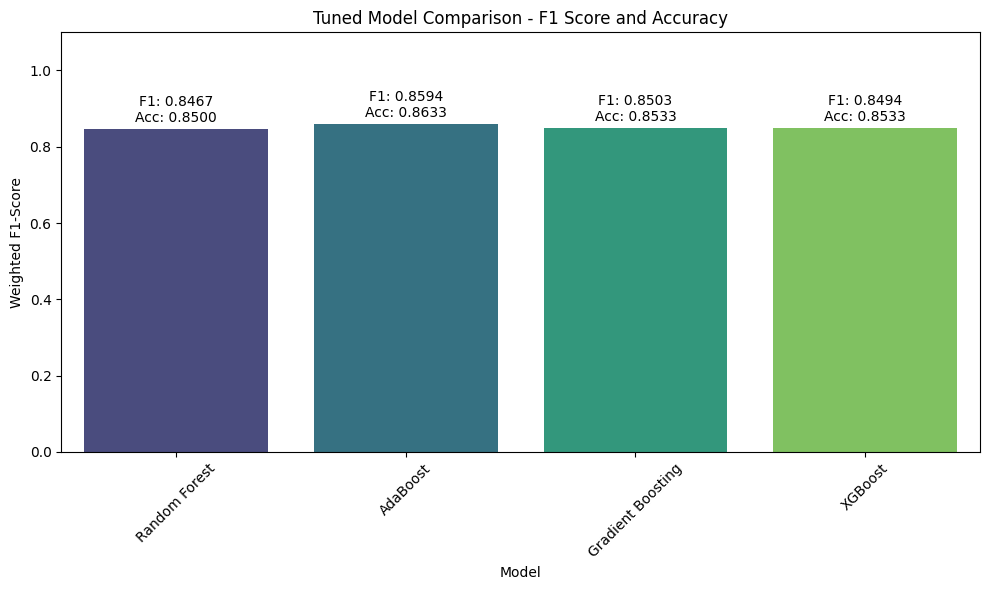

In [12]:
summary_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1-Score'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='F1-Score', hue='Model', data=summary_df, palette='viridis', legend=False)

for bar, (_, row) in zip(ax.patches, summary_df.iterrows()):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    f1 = row['F1-Score']
    acc = row['Accuracy']
    ax.text(
        x, y + 0.01,
        f"F1: {f1:.4f}\nAcc: {acc:.4f}",
        ha='center', va='bottom',
        fontsize=10
    )

plt.title('Tuned Model Comparison - F1 Score and Accuracy')
plt.ylabel('Weighted F1-Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Feature Importance of Fine-tuned Model

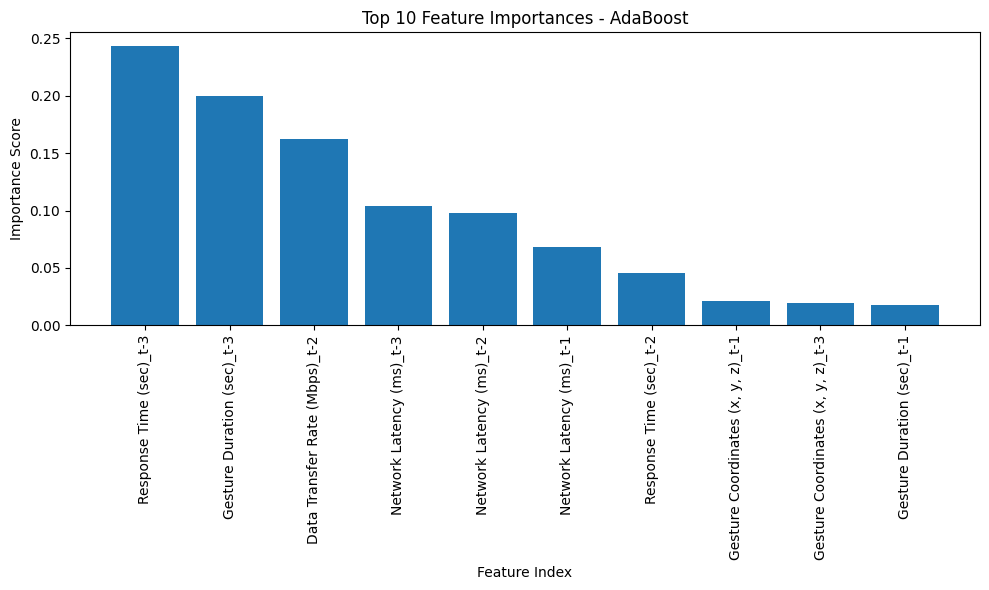

In [13]:
ada = AdaBoostClassifier(learning_rate=0.5, n_estimators=300, random_state=42)
ada.fit(X_train, y_train)
importances = ada.feature_importances_

base_features = context_rows.columns.tolist()
full_feature_names = []

for step in range(3):
    full_feature_names.extend([f"{f}_t-{3-step}" for f in base_features])

N = 10
indices = np.argsort(importances)[::-1][:N]

plt.figure(figsize=(10, 6))
plt.title(f"Top {N} Feature Importances - AdaBoost")
plt.bar(range(N), importances[indices], align="center")
plt.xticks(range(N), [full_feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

#### Feature Engineering

In [14]:
df_model['Latency_mean'] = df_model['Network Latency (ms)'].rolling(window=3).mean()
df_model['Duration_std'] = df_model['Gesture Duration (sec)'].rolling(window=3).std()


df_model['Δ_Response_t-2_t-1'] = df_model['Response Time (sec)'].shift(1) - df['Response Time (sec)'].shift(2)
df_model['Δ_Latency_t-3_t-2'] = df_model['Network Latency (ms)'].shift(2) - df['Network Latency (ms)'].shift(3)


df_model['latency_spike'] = (df_model['Network Latency (ms)'].diff().abs() > 50).astype(int)
df_model['duration_drop'] = (df_model['Gesture Duration (sec)'].diff() < -2).astype(int)

df_model['Latency_x_Duration'] = df_model['Network Latency (ms)'] * df['Gesture Duration (sec)']
df_model.head(10)

,Robot Gesture ID,Gesture Type,"Gesture Coordinates (x, y, z)",Timestamp,Gesture Duration (sec),Network Latency (ms),Data Transfer Rate (Mbps),Response Time (sec),Threat Detected,synthesized,Latency_mean,Duration_std,Δ_Response_t-2_t-1,Δ_Latency_t-3_t-2,latency_spike,duration_drop,Latency_x_Duration
0,10,2,737,0,7.2594,17.2405,98.8854,5.6023,1,1,NaN,NaN,NaN,NaN,0,0,125.155686
1,10,2,737,1,6.7795,16.1006,92.3475,5.2319,1,1,NaN,NaN,NaN,NaN,0,0,109.154018
2,10,2,737,2,6.5395,15.5307,89.0786,5.0467,1,1,16.290600,0.366552,-0.3704,NaN,0,0,101.563013
3,10,2,737,3,5.9995,14.2484,81.7235,4.6300,1,0,15.293233,0.399500,-0.1852,-1.1399,0,0,85.483276
4,8,1,805,4,2.7468,9.5467,119.9640,4.8462,1,1,13.108600,2.051675,-0.4167,-0.5699,0,1,26.222876
5,8,1,805,5,2.5458,8.8481,111.1861,4.4916,1,1,10.881067,1.938578,0.2162,-1.2823,0,0,22.525493
6,8,1,805,6,2.3895,8.3048,104.3589,4.2158,1,1,8.899867,0.179115,-0.3546,-4.7017,0,0,19.844320
7,8,1,805,7,2.2332,7.7615,97.5317,3.9400,1,0,8.304800,0.156300,-0.2758,-0.6986,0,0,17.332982
8,9,2,320,8,3.1971,13.2222,5.3000,0.0000,0,1,9.762833,0.517325,-0.2758,-0.5433,0,0,42.272696
9,9,2,320,9,3.1669,13.0975,5.2500,0.0000,0,1,11.360400,0.547998,-3.9400,-0.5433,0,0,41.478473



 AdaBoost with Feature Engineering:
Accuracy: 0.8733
Weighted F1-score: 0.8703

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.74      0.81       107
         1.0       0.87      0.95      0.91       193

    accuracy                           0.87       300
   macro avg       0.88      0.84      0.86       300
weighted avg       0.87      0.87      0.87       300



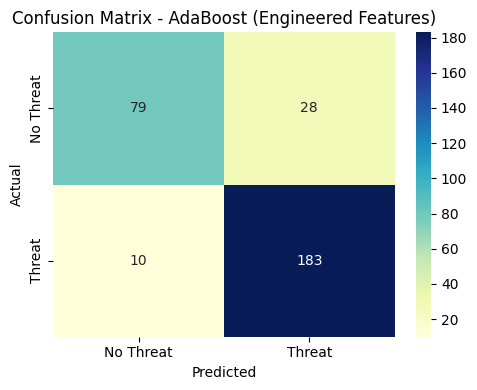

In [15]:
sequence_data = []
sequence_labels = []

for i in range(len(df_model) - 3):
    rows = df_model.iloc[i:i+4]
    if list(rows['synthesized']) == [label_encoders['synthesized'].transform(['yes'])[0]] * 3 + [label_encoders['synthesized'].transform(['no'])[0]]:
        context_rows = rows.iloc[:3].drop(columns=['Timestamp', 'Threat Detected', 'synthesized'])
        label = rows.iloc[3]['Threat Detected']
        flattened = context_rows.values.flatten()
        sequence_data.append(flattened)
        sequence_labels.append(label)

X = np.array(sequence_data)
y = np.array(sequence_labels)

X = SimpleImputer(strategy='mean').fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

ada = AdaBoostClassifier(
    n_estimators=200,
    random_state=42
)
ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']

print(f"\n AdaBoost with Feature Engineering:")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1-score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['No Threat', 'Threat'], yticklabels=['No Threat', 'Threat'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - AdaBoost (Engineered Features)')
plt.tight_layout()
plt.show()

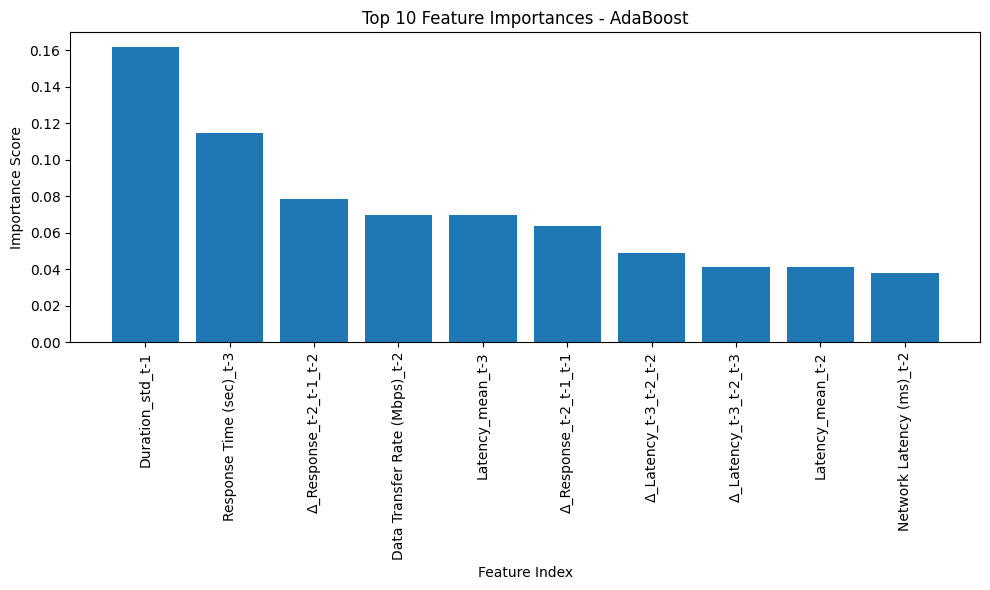

In [16]:
importances = ada.feature_importances_

base_features = context_rows.columns.tolist()
full_feature_names = []

for step in range(3):
    full_feature_names.extend([f"{f}_t-{3-step}" for f in base_features])

N = 10
indices = np.argsort(importances)[::-1][:N]

plt.figure(figsize=(10, 6))
plt.title(f"Top {N} Feature Importances - AdaBoost")
plt.bar(range(N), importances[indices], align="center")
plt.xticks(range(N), [full_feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

#### Precision-recall 

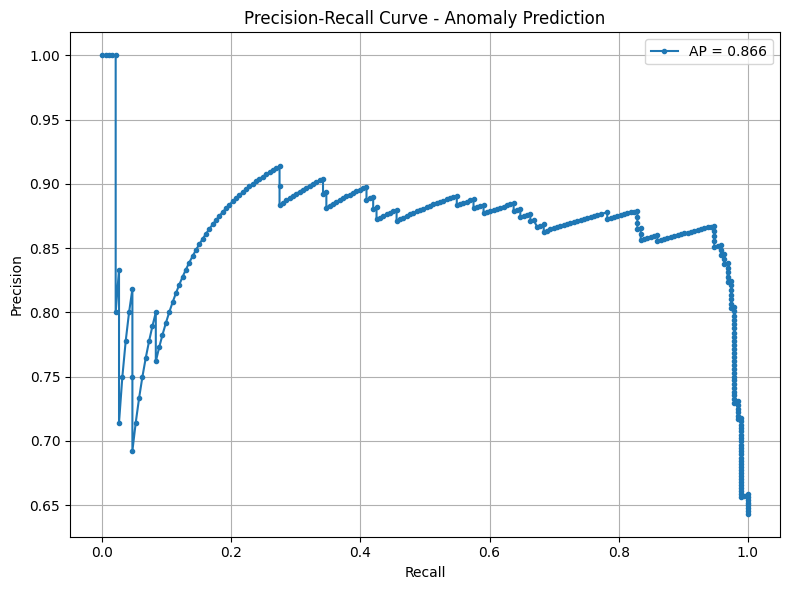

In [17]:
y_probs = ada.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'AP = {ap_score:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Anomaly Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()